In [30]:
import pandas as pd 
aguadataframe = pd.read_csv('Calidad_de_agua_2022.csv',delimiter = ';')
aguadataframe
aguadataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   orden                    168 non-null    int64 
 1   sitios                   168 non-null    object
 2   codigo                   168 non-null    object
 3   fecha                    168 non-null    object
 4   año                      168 non-null    object
 5   campaña                  168 non-null    object
 6   tem_agua                 168 non-null    object
 7   tem_aire                 166 non-null    object
 8   od                       168 non-null    object
 9   ph                       168 non-null    object
 10  olores                   168 non-null    object
 11  color                    168 non-null    object
 12  espumas                  168 non-null    object
 13  mat_susp                 168 non-null    object
 14  colif_fecales_ufc_100ml  167 non-null    o

viendo la informacion del dataset, se puede ver que hay algunas columnas que contienen valores nulos (informacion para un posterior analisis) y ademas que todas las columnas son de tipo objet lo cual nos da un indicio de que algunas columnas vamos a tener que transformarlas y cambiarlas de tipo. 

In [31]:
aguadataframe = aguadataframe.drop(columns='orden')
aguadataframe = aguadataframe.drop(columns='año')
aguadataframe = aguadataframe.drop(columns='fecha')
aguadataframe = aguadataframe.drop(columns='cd_total_mg_l')
aguadataframe = aguadataframe.drop(columns='calidad_de_agua')
aguadataframe = aguadataframe.drop(columns='hidr_deriv_petr_ug_l')
aguadataframe = aguadataframe.drop(columns='codigo')
aguadataframe = aguadataframe.drop(columns='sitios')

In [32]:
aguadataframe1 = aguadataframe.copy()
aguadataframe1 = aguadataframe1.replace({"no se midió": pd.NA,
                                         "no midieron este día": pd.NA,
                                         "no se determinó": pd.NA,
                                         "no midio la sonda": pd.NA})
aguadataframe1 = aguadataframe1.dropna(thresh=15)

In [33]:
columnas_numericas=['tem_agua', 'tem_aire', 'od', 'ph','turbiedad_ntu','ica']
aguadataframe1[columnas_numericas]=aguadataframe[columnas_numericas].replace(',', '.', regex=True).apply(pd.to_numeric, errors='coerce')


In [34]:
boolean_columns = ['espumas', 'olores', 'color', 'mat_susp']
for col in boolean_columns:
    aguadataframe1[col] = aguadataframe1[col].replace({'Presencia': True,
                                                       'Ausencia': False,
                                                       'ausencia': False,
                                                       'Ausente': False,
                                                       }).astype(bool)

C:\Users\Ramiro\AppData\Local\Temp\ipykernel_13404\1186107394.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  aguadataframe1[col] = aguadataframe1[col].replace({'Presencia': True,
C:\Users\Ramiro\AppData\Local\Temp\ipykernel_13404\1186107394.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  aguadataframe1[col] = aguadataframe1[col].replace({'Presencia': True,
C:\Users\Ramiro\AppData\Local\Temp\ipykernel_13404\1186107394.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future versi

In [35]:
for col in ['cr_total_mg_l', 'clorofila_a_ug_l', 'microcistina_ug_l','nitrato_mg_l','nh4_mg_l','p_total_l_mg_l',
            'fosf_ortofos_mg_l','dbo_mg_l','dqo_mg_l','enteroc_ufc_100ml','escher_coli_ufc_100ml','colif_fecales_ufc_100ml']:  # Ajustá con el nombre de tus columnas
    aguadataframe1[col] = aguadataframe1[col].str.replace(r'^\s*<\s*', '', regex=True)  # Elimina "<" o " <" al inicio
    aguadataframe1[col] = pd.to_numeric(aguadataframe1[col], errors='coerce')  # Convierte a numérico

In [36]:
aguadataframe1 = pd.get_dummies(aguadataframe1, columns=['campaña'])

In [37]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
columnas_numericas = aguadataframe1.select_dtypes(include='number')
aguadataframe1[columnas_numericas.columns] = imputer.fit_transform(columnas_numericas).round(3)

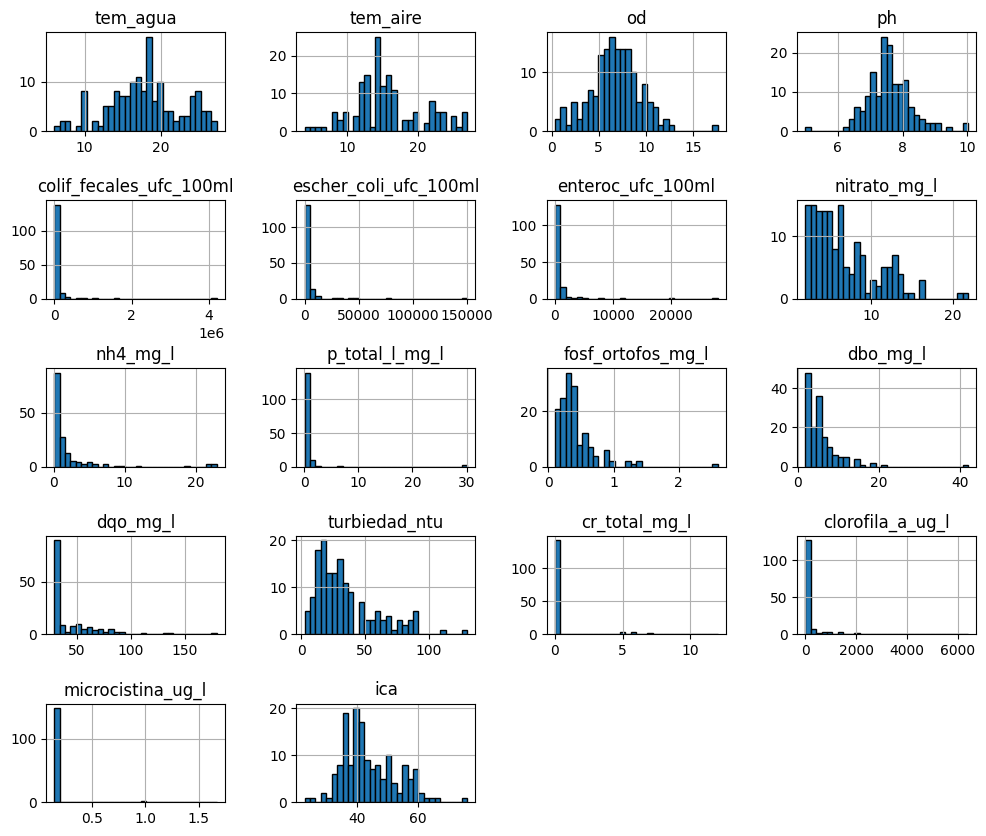

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
aguadataframe1.hist(figsize=(12,10),bins=30,edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

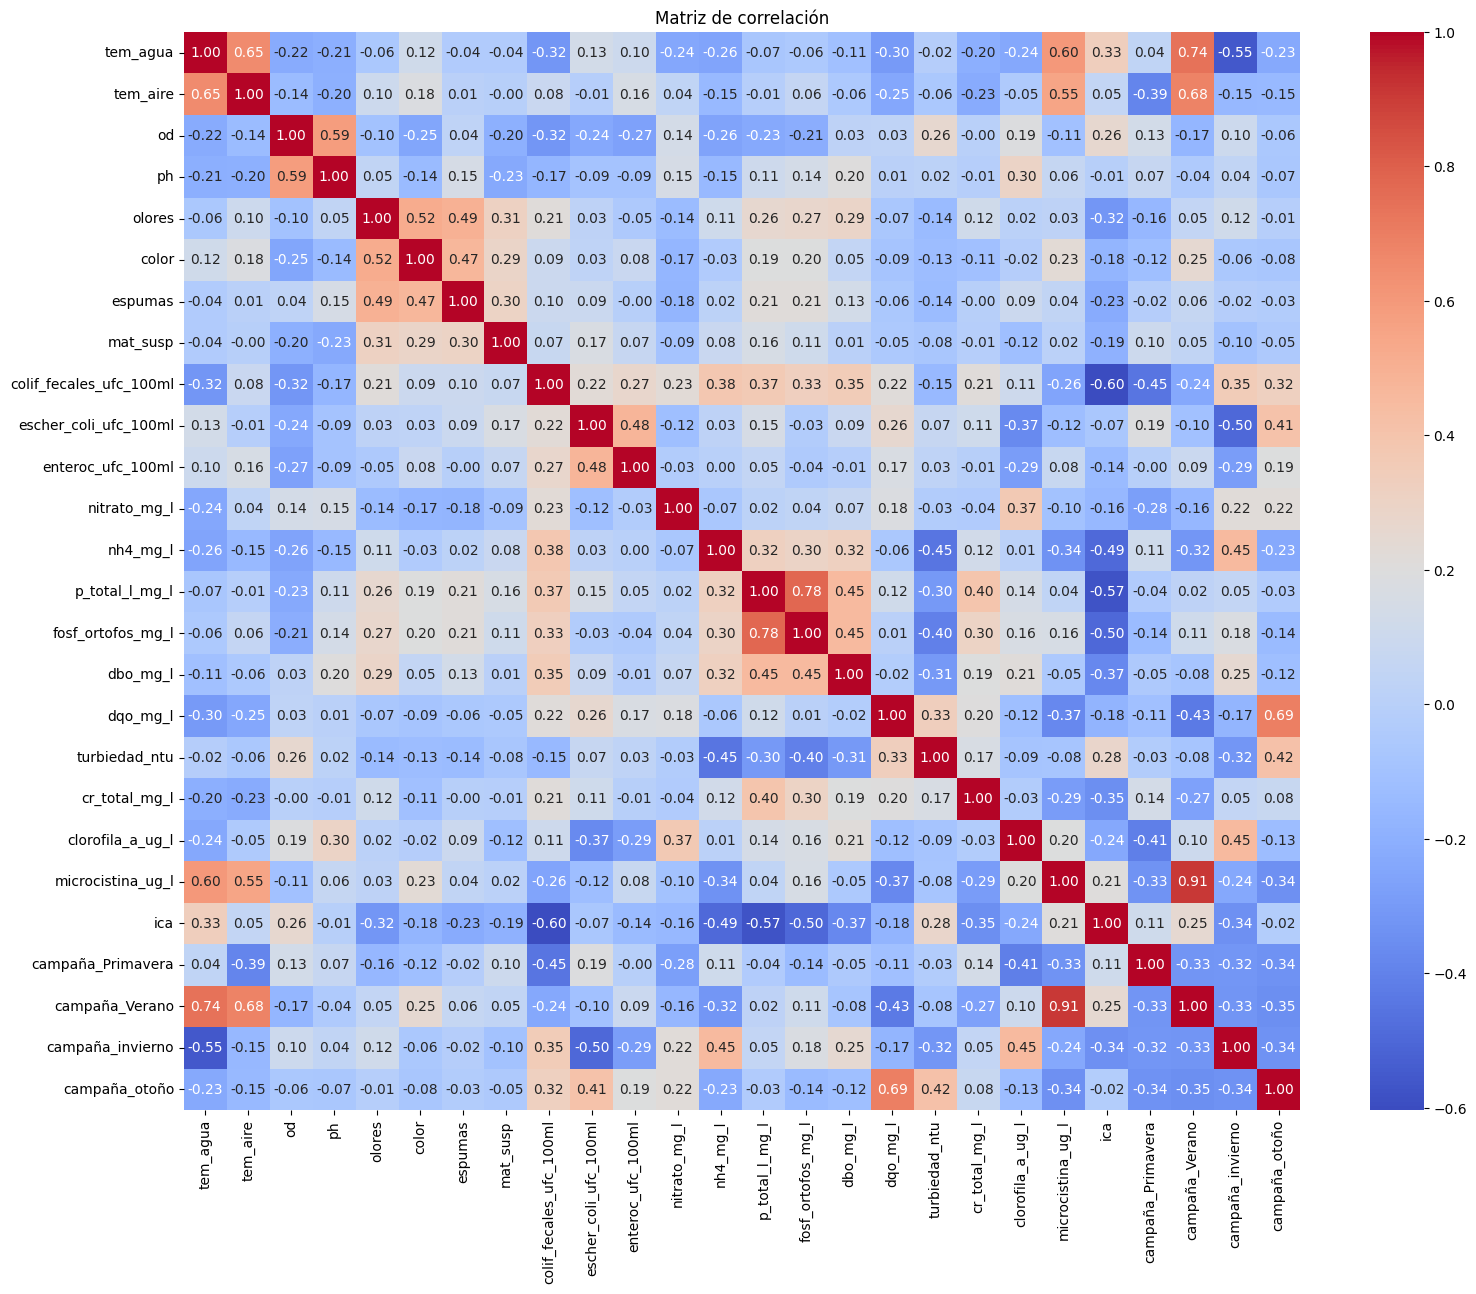

In [39]:
import seaborn as sns

plt.figure(figsize=(18,14))
sns.heatmap(aguadataframe1.corr(method='spearman'), annot=True, cmap='coolwarm', fmt='.2f') #spearman es mejor con muchos outlier y poca normalidad 
plt.title('Matriz de correlación')
plt.show()

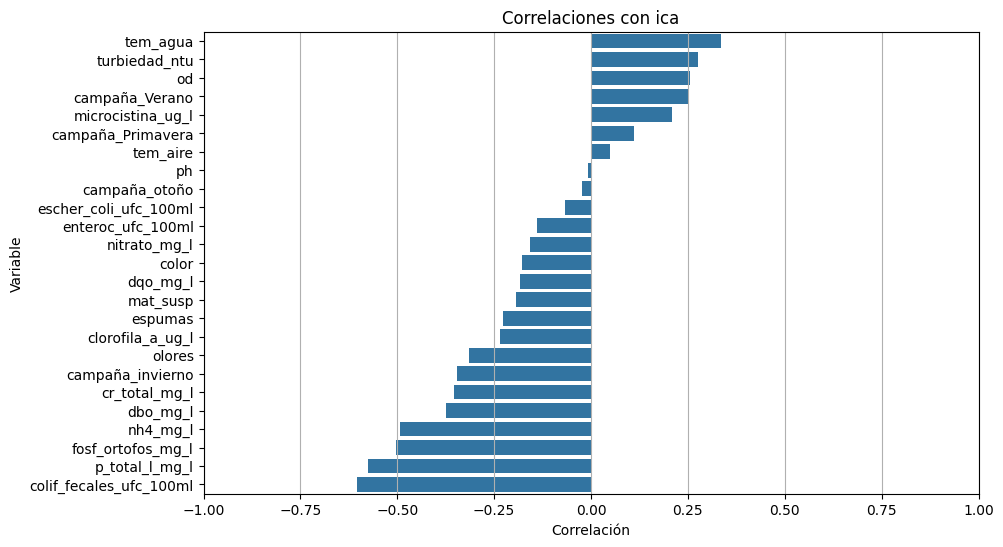

In [40]:
ica_correlaciones = aguadataframe1.corr(method='spearman')['ica'].drop('ica')
correlaciones_ordenadas = ica_correlaciones.sort_values(ascending=False)

plt.figure(figsize=(10,6))
plt.grid(True)
sns.barplot(x=correlaciones_ordenadas.values, y=correlaciones_ordenadas.index)
plt.title('Correlaciones con ica')
plt.xlabel('Correlación')
plt.ylabel('Variable')
plt.xlim([-1,1])
plt.show()

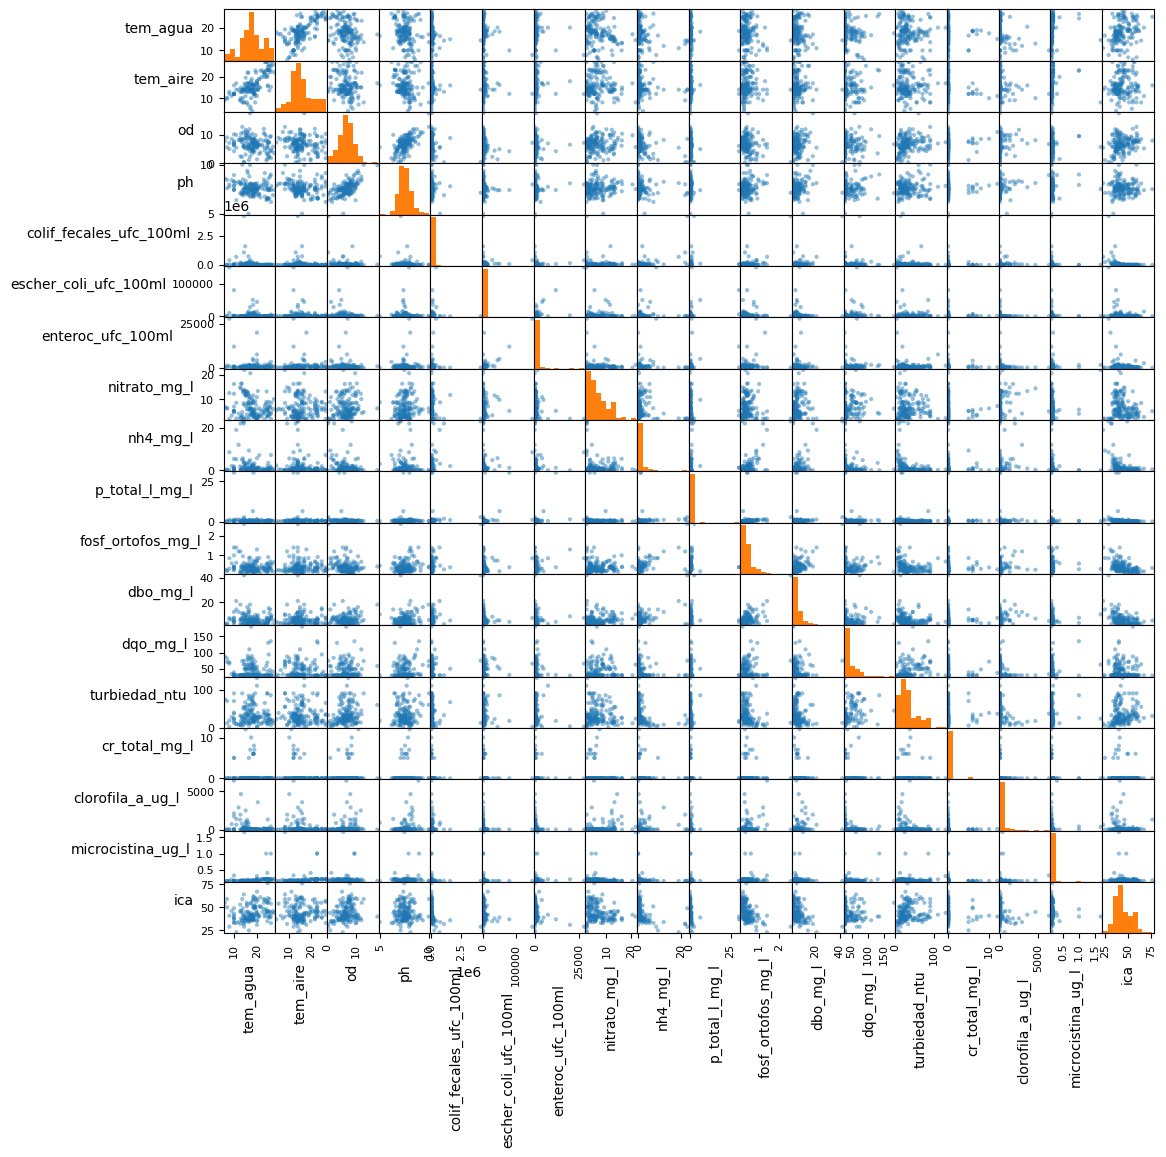

In [41]:
numeric_cols = aguadataframe1.select_dtypes(include=['number'])

# Crear el scatter matrix
axs = pd.plotting.scatter_matrix(numeric_cols, figsize=(12, 12), alpha=0.47, hist_kwds={'color':'#ff7f0e'})
# la mostramos por pantalla
# acomodamos la orientación del contenido de los ejes
for i in range(len(numeric_cols.columns)):
  for j in range(len(numeric_cols.columns)):
    ax=axs[i,j]
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
plt.show()

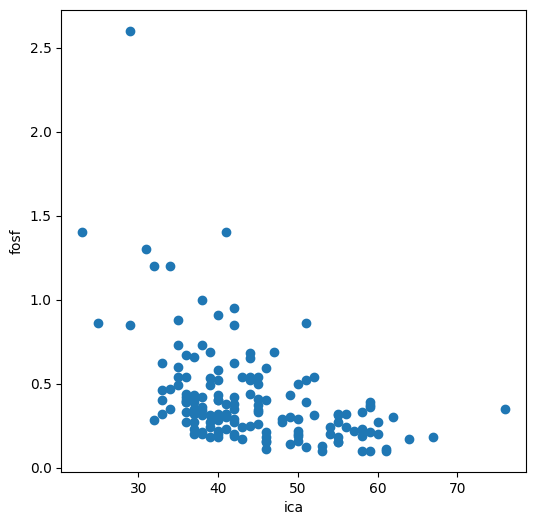

In [42]:
plt.figure(figsize=(6,6))
plt.scatter(aguadataframe1['ica'],aguadataframe1['fosf_ortofos_mg_l'])

plt.xlabel('ica')
plt.ylabel('fosf')
plt.show()

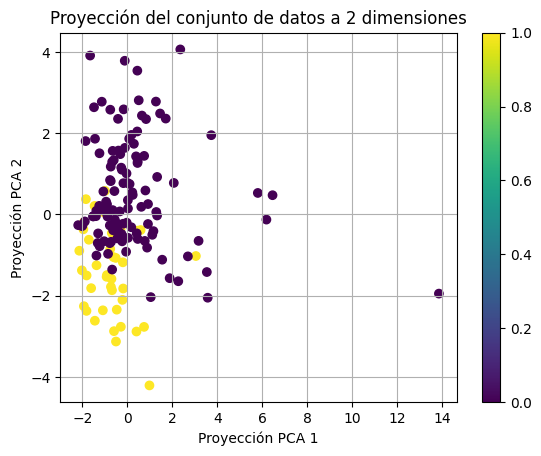

In [43]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

x = aguadataframe1.select_dtypes(include='number')

#x.drop('ica',axis=1)

scaler = StandardScaler()

x_escalada = scaler.fit_transform(x)

pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_escalada)

plt.scatter(x_pca[:,0], x_pca[:,1], c=aguadataframe1['campaña_Verano'], cmap = 'viridis')
plt.grid(True)
#plt.xlim(-7,-5)
#plt.ylim(-5,5)
plt.xlabel('Proyección PCA 1')
plt.ylabel('Proyección PCA 2')
plt.title('Proyección del conjunto de datos a 2 dimensiones')
plt.colorbar()
plt.show()

Before t-SNE: (154, 18)
After t-SNE: (154, 2)


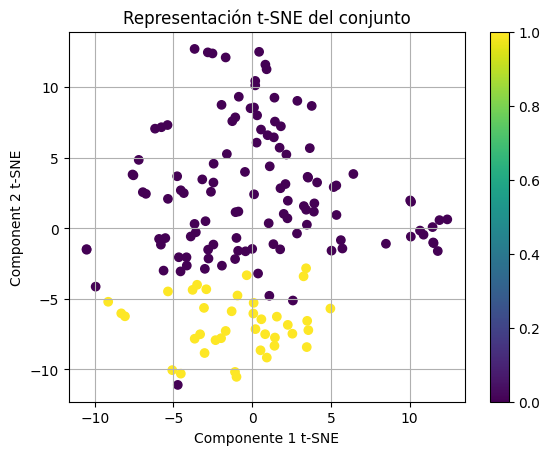

In [44]:
from sklearn.manifold import TSNE

# creamos el objeto, lo fitteamos en nuestros datos y lo aplicamos sobre esos mismos
#X_tsne = TSNE(n_components=2).fit_transform(X_train_stand) # sin random state
X_tsne = TSNE(n_components=2, random_state=10).fit_transform(x_escalada)  # con random state
# imprimimos los tamaños antes y después
print('Before t-SNE: {}'.format(x_escalada.shape))
print('After t-SNE: {}'.format(X_tsne.shape))

# graficamos los datos, el color de cada punto representa el valor de la casa
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=aguadataframe1["campaña_Verano"], cmap='viridis')
plt.grid(True)
plt.xlabel('Componente 1 t-SNE')
plt.ylabel('Component 2 t-SNE')
plt.title('Representación t-SNE del conjunto')
plt.colorbar()
plt.show()

Antes de UMAP: (154, 18)
Después de UMAP: (154, 2)


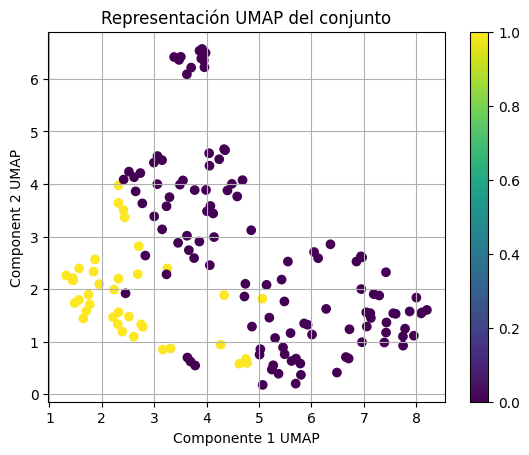

In [45]:
import umap.umap_ as umap

# creamos el objeto, lo fitteamos en nuestros datos y lo aplicamos sobre esos mismos
X_umap = umap.UMAP(n_components=2).fit_transform(x_escalada)
# imprimimos los tamaños antes y después
print('Antes de UMAP: {}'.format(x_escalada.shape))
print('Después de UMAP: {}'.format(X_umap.shape))

# graficamos los datos, el color de cada punto representa el valor de la casa
plt.scatter(X_umap[:,0], X_umap[:,1], c=aguadataframe1["campaña_Verano"], cmap='viridis')
plt.grid(True)
plt.xlabel('Componente 1 UMAP')
plt.ylabel('Component 2 UMAP')
plt.title('Representación UMAP del conjunto')
plt.colorbar()
plt.show()

In [46]:
aguadataframe1.to_csv('aguitaFRESCA.csv')

Hipótesis 1: La calidad del agua se ve afectada por la presencia de bacterias fecales

C:\Users\Ramiro\AppData\Local\Temp\ipykernel_13404\214955739.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlaciones_ordenadas.values, y=correlaciones_ordenadas.index, palette=colores)


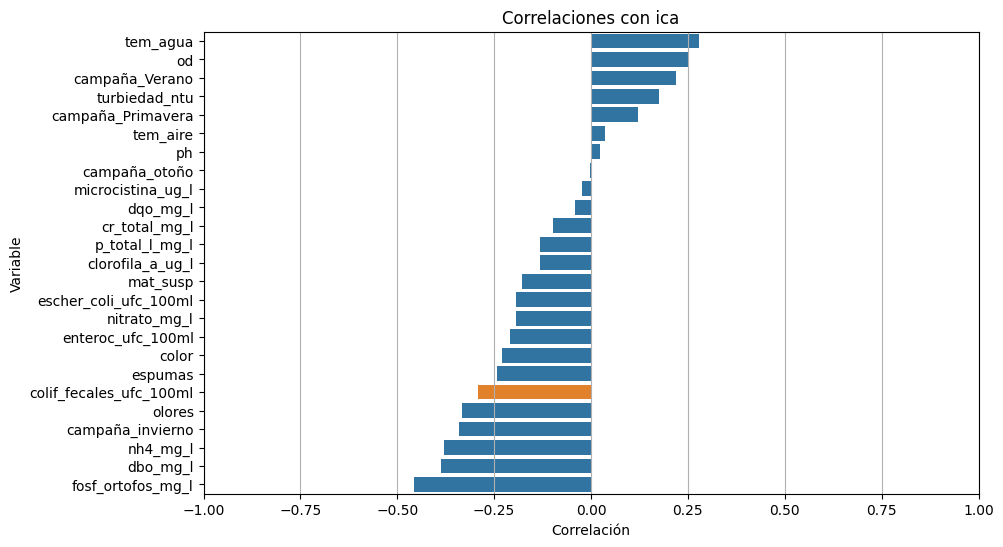

In [47]:
ica_correlaciones = aguadataframe1.corr()['ica'].drop('ica')
correlaciones_ordenadas = ica_correlaciones.sort_values(ascending=False)

colores = ['#1f77b4' if variable != 'colif_fecales_ufc_100ml' else '#ff7f0e' for variable in correlaciones_ordenadas.index]

plt.figure(figsize=(10,6))
plt.grid(True)
sns.barplot(x=correlaciones_ordenadas.values, y=correlaciones_ordenadas.index, palette=colores)
plt.title('Correlaciones con ica')
plt.xlabel('Correlación')
plt.ylabel('Variable')
plt.xlim([-1,1])
plt.show()

In [48]:
from scipy.stats import shapiro

# Test de Shapiro-Wilk para países desarrollados
stat, p = shapiro(aguadataframe1['ica'])
print(f"Test de Shapiro-Wilk para ica: Estadístico={stat:.3f}, p-valor={p:.3f}")

# Test de Shapiro-Wilk para países en vías de desarrollo
stat, p = shapiro(aguadataframe1['colif_fecales_ufc_100ml'])
print(f"Test de Shapiro-Wilk para colif_fecales_ufc_100ml: Estadístico={stat:.3f}, p-valor={p:.3f}")

Test de Shapiro-Wilk para ica: Estadístico=0.959, p-valor=0.000
Test de Shapiro-Wilk para colif_fecales_ufc_100ml: Estadístico=0.212, p-valor=0.000


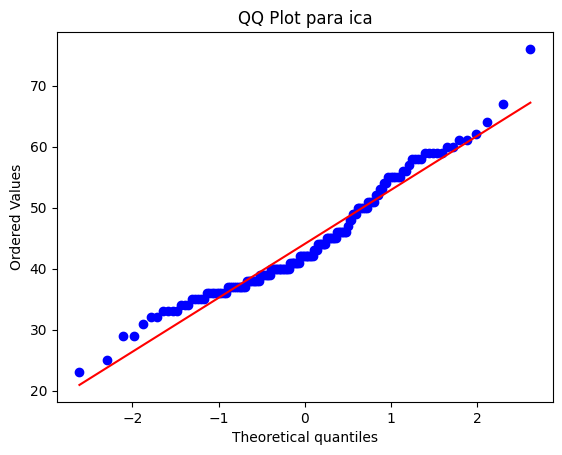

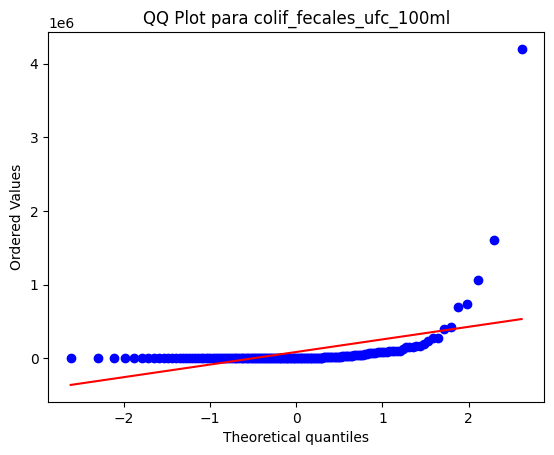

In [49]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# QQ plot para países desarrollados
stats.probplot(aguadataframe1['ica'], dist="norm", plot=plt)
plt.title("QQ Plot para ica")
plt.show()

# QQ plot para países en vías de desarrollo
stats.probplot(aguadataframe1['colif_fecales_ufc_100ml'], dist="norm", plot=plt)
plt.title("QQ Plot para colif_fecales_ufc_100ml")
plt.show()

In [50]:
stat, p = stats.levene(aguadataframe1['ica'], aguadataframe1['colif_fecales_ufc_100ml'])
print(f"Test de Levene : Estadístico={stat:.3f}, p-valor={p:.3f}")

Test de Levene : Estadístico=7.679, p-valor=0.006


In [51]:
aguadataframe1['colif_fecales_ufc_100ml'].value_counts()
umbral = aguadataframe1['colif_fecales_ufc_100ml'].quantile(0.50)
grupo_bajo = aguadataframe1[aguadataframe1['colif_fecales_ufc_100ml'] < umbral]
grupo_alto = aguadataframe1[aguadataframe1['colif_fecales_ufc_100ml'] >= umbral]

# Verificar el tamaño de cada grupo
print("Grupo bajo:", grupo_bajo.shape[0])
print("Grupo alto:", grupo_alto.shape[0])

stat, p = stats.levene(grupo_bajo['ica'], grupo_alto['ica'])
print(f"Test de Levene para ica en ambos grupos: Estadístico={stat:.3f}, p-valor={p:.3f}")

Grupo bajo: 77
Grupo alto: 77
Test de Levene para ica en ambos grupos: Estadístico=10.641, p-valor=0.001


como los datos no son homocedasticos  nos vamos a hacer el test de kruskal

In [52]:
# Test de Kruskal-Wallis para comparar muestras de agua con alta concentracion de coliferos y bajos 
stat, p = stats.kruskal(grupo_bajo['ica'],grupo_alto['ica'])
print(f"Test de Kruskal-Wallis para grupos_colif Estadístico={stat:.3f}, p-valor={p:.3f}")

# Interpretación de los resultados
alpha = 0.05  # Nivel de significancia
if p > alpha:
    print("No hay suficiente evidencia para rechazar la hipótesis nula.")
    print("No hay diferencia entre los grupos")
else:
    print("Se rechaza la hipótesis nula.")
    print("Existe una diferencia significativa ")

Test de Kruskal-Wallis para grupos_colif Estadístico=45.127, p-valor=0.000
Se rechaza la hipótesis nula.
Existe una diferencia significativa 


C:\Users\Ramiro\AppData\Local\Temp\ipykernel_13404\1367569528.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo_bajo['concentracion_coliformes'] = 'Baja'
C:\Users\Ramiro\AppData\Local\Temp\ipykernel_13404\1367569528.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo_alto['concentracion_coliformes'] = 'Alta'


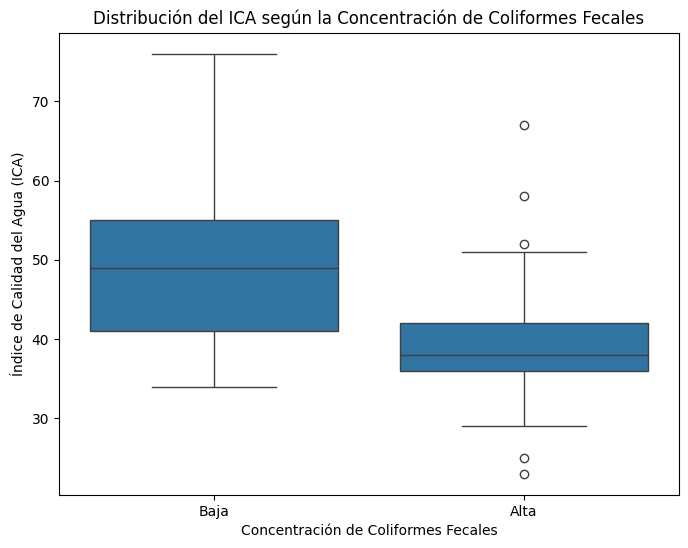

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear una nueva columna que indique el grupo (alta o baja concentración)
grupo_bajo['concentracion_coliformes'] = 'Baja'
grupo_alto['concentracion_coliformes'] = 'Alta'

# Concatenar los dos grupos en un solo DataFrame para facilitar el graficado
df_concentracion = pd.concat([grupo_bajo, grupo_alto])

# Crear el boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_concentracion, x='concentracion_coliformes', y='ica')
plt.title('Distribución del ICA según la Concentración de Coliformes Fecales')
plt.xlabel('Concentración de Coliformes Fecales')
plt.ylabel('Índice de Calidad del Agua (ICA)')
plt.show()

Hipótesis 2: La concentración de bacterias fecales varía según la estación del año

In [54]:
from scipy.stats import shapiro

primavera = aguadataframe1[aguadataframe1['campaña_Primavera'] == True]
verano = aguadataframe1[aguadataframe1['campaña_Verano'] == True]
invierno = aguadataframe1[aguadataframe1['campaña_invierno'] == True]
otoño = aguadataframe1[aguadataframe1['campaña_otoño'] == True]

#Test de Shapiro-Wilk para países en vías de desarrollo
stat, p = shapiro(primavera['colif_fecales_ufc_100ml'])
print(f"Test de Shapiro-Wilk para colif_fecales_ufc_100ml: Estadístico={stat:.3f}, p-valor={p:.3f}")
stat, p = shapiro(verano['colif_fecales_ufc_100ml'])
print(f"Test de Shapiro-Wilk para colif_fecales_ufc_100ml: Estadístico={stat:.3f}, p-valor={p:.3f}")
stat, p = shapiro(invierno['colif_fecales_ufc_100ml'])
print(f"Test de Shapiro-Wilk para colif_fecales_ufc_100ml: Estadístico={stat:.3f}, p-valor={p:.3f}")
stat, p = shapiro(otoño['colif_fecales_ufc_100ml'])
print(f"Test de Shapiro-Wilk para colif_fecales_ufc_100ml: Estadístico={stat:.3f}, p-valor={p:.3f}")


Test de Shapiro-Wilk para colif_fecales_ufc_100ml: Estadístico=0.315, p-valor=0.000
Test de Shapiro-Wilk para colif_fecales_ufc_100ml: Estadístico=0.260, p-valor=0.000
Test de Shapiro-Wilk para colif_fecales_ufc_100ml: Estadístico=0.389, p-valor=0.000
Test de Shapiro-Wilk para colif_fecales_ufc_100ml: Estadístico=0.701, p-valor=0.000


In [55]:
from scipy.stats import levene

# Aplicar el test de Levene para comparar las varianzas entre las estaciones
stat, p = levene(primavera['colif_fecales_ufc_100ml'], 
                 verano['colif_fecales_ufc_100ml'], 
                 invierno['colif_fecales_ufc_100ml'], 
                 otoño['colif_fecales_ufc_100ml'])

# Mostrar el resultado
print(f"Test de Levene para homocedasticidad en colif_fecales_ufc_100ml entre estaciones: Estadístico={stat:.3f}, p-valor={p:.3f}")

Test de Levene para homocedasticidad en colif_fecales_ufc_100ml entre estaciones: Estadístico=4.016, p-valor=0.009


vamos a realizar el test de kruskal nuevamente ya que tampoco los datos son homocedasticos 

In [56]:
from scipy.stats import kruskal

# Aplicar el test de Kruskal-Wallis
stat, p = kruskal(primavera['colif_fecales_ufc_100ml'], 
                  verano['colif_fecales_ufc_100ml'], 
                  invierno['colif_fecales_ufc_100ml'], 
                  otoño['colif_fecales_ufc_100ml'])

# Mostrar el resultado
print(f"Test de Kruskal-Wallis para concentraciones de coliformes fecales entre estaciones: Estadístico={stat:.3f}, p-valor={p:.3f}")

# Interpretación del resultado
if p > alpha:
    print("No hay suficiente evidencia para rechazar la hipótesis nula.")
    print("No hay diferencias significativas en las concentraciones de bacterias fecales entre las estaciones.")
else:
    print("Se rechaza la hipótesis nula.")
    print("Existen diferencias significativas en las concentraciones de bacterias fecales entre las estaciones.")


Test de Kruskal-Wallis para concentraciones de coliformes fecales entre estaciones: Estadístico=55.719, p-valor=0.000
Se rechaza la hipótesis nula.
Existen diferencias significativas en las concentraciones de bacterias fecales entre las estaciones.


C:\Users\Ramiro\AppData\Local\Temp\ipykernel_13404\1510191162.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=aguadataframe1, x='estacion', y='colif_fecales_ufc_100ml', palette="Set2")


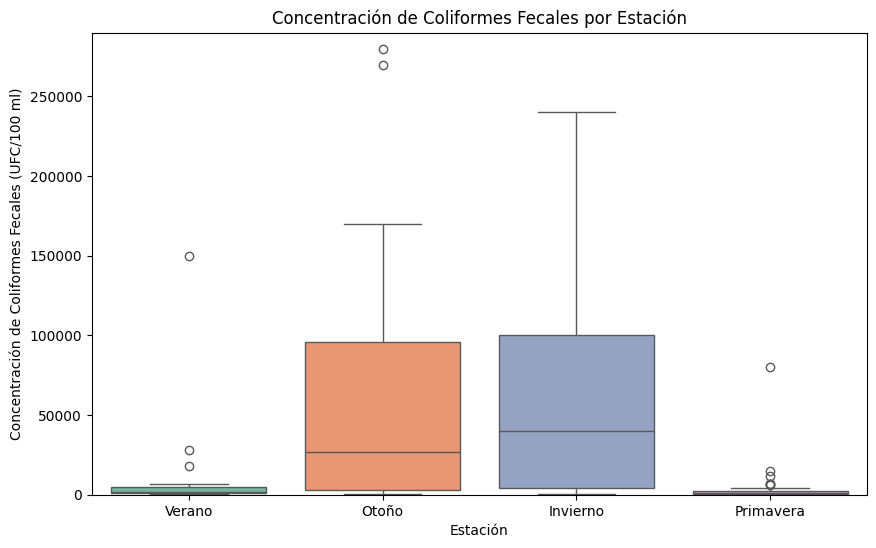

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear una columna en el DataFrame original para indicar la estación
aguadataframe1['estacion'] = None
aguadataframe1.loc[aguadataframe1['campaña_Primavera'] == True, 'estacion'] = 'Primavera'
aguadataframe1.loc[aguadataframe1['campaña_Verano'] == True, 'estacion'] = 'Verano'
aguadataframe1.loc[aguadataframe1['campaña_invierno'] == True, 'estacion'] = 'Invierno'
aguadataframe1.loc[aguadataframe1['campaña_otoño'] == True, 'estacion'] = 'Otoño'

# Graficar un boxplot para cada estación
plt.figure(figsize=(10, 6))
sns.boxplot(data=aguadataframe1, x='estacion', y='colif_fecales_ufc_100ml', palette="Set2")
plt.title('Concentración de Coliformes Fecales por Estación')
plt.xlabel('Estación')
plt.ylabel('Concentración de Coliformes Fecales (UFC/100 ml)')
plt.ylim(0, 290000)  # Ajusta este rango según los valores que deseas visualizar
plt.show()


Hipótesis 5: Las zonas con menor calidad de agua presentan mayor turbidez. 

In [ ]:
import pandas as pd
from scipy.stats import levene

# Definir los umbrales de los cuartiles para la variable 'turbiedad_ntu'
umbral1 = aguadataframe1['turbiedad_ntu'].quantile(0.25)
umbral2 = aguadataframe1['turbiedad_ntu'].quantile(0.50)
umbral3 = aguadataframe1['turbiedad_ntu'].quantile(0.75)

# Filtrar los grupos según los umbrales definidos
grupo1 = aguadataframe1[aguadataframe1['turbiedad_ntu'] <= umbral1]
grupo2 = aguadataframe1[(aguadataframe1['turbiedad_ntu'] > umbral1) & (aguadataframe1['turbiedad_ntu'] <= umbral2)]
grupo3 = aguadataframe1[(aguadataframe1['turbiedad_ntu'] > umbral2) & (aguadataframe1['turbiedad_ntu'] <= umbral3)]
grupo4 = aguadataframe1[aguadataframe1['turbiedad_ntu'] > umbral3]

# Test de Levene para homocedasticidad entre los grupos en la variable 'ica'
stat, p = levene(grupo1['ica'], 
                 grupo2['ica'], 
                 grupo3['ica'], 
                 grupo4['ica'])

print(f"Test de Levene para homocedasticidad en ica entre grupos: Estadístico={stat:.3f}, p-valor={p:.3f}")

stat, p = shapiro(grupo1['ica'])
print(f"Test de Shapiro-Wilk para: Estadístico={stat:.3f}, p-valor={p:.3f}")
stat, p = shapiro(grupo2['ica'])
print(f"Test de Shapiro-Wilk para : Estadístico={stat:.3f}, p-valor={p:.3f}")
stat, p = shapiro(grupo3['ica'])
print(f"Test de Shapiro-Wilk para : Estadístico={stat:.3f}, p-valor={p:.3f}")
stat, p = shapiro(grupo4['ica'])
print(f"Test de Shapiro-Wilk para: Estadístico={stat:.3f}, p-valor={p:.3f}")

Test de Levene para homocedasticidad en ica entre grupos: Estadístico=1.078, p-valor=0.360
Test de Shapiro-Wilk para: Estadístico=0.977, p-valor=0.564
Test de Shapiro-Wilk para : Estadístico=0.914, p-valor=0.007
Test de Shapiro-Wilk para : Estadístico=0.953, p-valor=0.084
Test de Shapiro-Wilk para: Estadístico=0.857, p-valor=0.000


como los datos son homecedasticos pero no normales , podemos hacer un mann whitney dijo el chino

In [ ]:
from scipy.stats import mannwhitneyu

# Realizar el test de Mann-Whitney U entre los grupos
# Grupo 1 vs Grupo 2
stat, p = mannwhitneyu(grupo1['ica'], grupo2['ica'], alternative='two-sided')
print(f"Test de Mann-Whitney U (Grupo 1 vs Grupo 2) en ICA: Estadístico={stat:.3f}, p-valor={p:.3f}")

# Grupo 1 vs Grupo 3
stat, p = mannwhitneyu(grupo1['ica'], grupo3['ica'], alternative='two-sided')
print(f"Test de Mann-Whitney U (Grupo 1 vs Grupo 3) en ICA: Estadístico={stat:.3f}, p-valor={p:.3f}")

# Grupo 1 vs Grupo 4
stat, p = mannwhitneyu(grupo1['ica'], grupo4['ica'], alternative='two-sided')
print(f"Test de Mann-Whitney U (Grupo 1 vs Grupo 4) en ICA: Estadístico={stat:.3f}, p-valor={p:.3f}")

# Grupo 2 vs Grupo 3
stat, p = mannwhitneyu(grupo2['ica'], grupo3['ica'], alternative='two-sided')
print(f"Test de Mann-Whitney U (Grupo 2 vs Grupo 3) en ICA: Estadístico={stat:.3f}, p-valor={p:.3f}")

# Grupo 2 vs Grupo 4
stat, p = mannwhitneyu(grupo2['ica'], grupo4['ica'], alternative='two-sided')
print(f"Test de Mann-Whitney U (Grupo 2 vs Grupo 4) en ICA: Estadístico={stat:.3f}, p-valor={p:.3f}")

# Grupo 3 vs Grupo 4
stat, p = mannwhitneyu(grupo3['ica'], grupo4['ica'], alternative='two-sided')
print(f"Test de Mann-Whitney U (Grupo 3 vs Grupo 4) en ICA: Estadístico={stat:.3f}, p-valor={p:.3f}")


Test de Mann-Whitney U (Grupo 1 vs Grupo 2) en ICA: Estadístico=469.500, p-valor=0.006
Test de Mann-Whitney U (Grupo 1 vs Grupo 3) en ICA: Estadístico=368.000, p-valor=0.000
Test de Mann-Whitney U (Grupo 1 vs Grupo 4) en ICA: Estadístico=449.000, p-valor=0.008
Test de Mann-Whitney U (Grupo 2 vs Grupo 3) en ICA: Estadístico=547.000, p-valor=0.024
Test de Mann-Whitney U (Grupo 2 vs Grupo 4) en ICA: Estadístico=643.000, p-valor=0.006
Test de Mann-Whitney U (Grupo 3 vs Grupo 4) en ICA: Estadístico=897.000, p-valor=0.098


In [72]:
from scipy.stats import mannwhitneyu

# Definir el umbral de la mediana para la variable 'turbiedad_ntu'
umbral_median = aguadataframe1['turbiedad_ntu'].median()

# Dividir en dos grupos: baja turbiedad (<= mediana) y alta turbiedad (> mediana)
grupo_bajo = aguadataframe1[aguadataframe1['turbiedad_ntu'] <= umbral_median]
grupo_alto = aguadataframe1[aguadataframe1['turbiedad_ntu'] > umbral_median]

# Verificar el tamaño de cada grupo
print("Grupo de baja turbiedad:", grupo_bajo.shape[0])
print("Grupo de alta turbiedad:", grupo_alto.shape[0])

# Test de Mann-Whitney U para comparar los grupos en la variable 'ica'
stat, p = mannwhitneyu(grupo_bajo['ica'], grupo_alto['ica'], alternative='two-sided')
print(f"Test de Mann-Whitney U (Baja vs Alta Turbiedad) en ICA: Estadístico={stat:.3f}, p-valor={p:.3f}")

# Interpretación de los resultados
alpha = 0.05  # Nivel de significancia
if p > alpha:
    print("No hay suficiente evidencia para rechazar la hipótesis nula.")
    print("No hay diferencia significativa en ICA entre los grupos de baja y alta turbiedad.")
else:
    print("Se rechaza la hipótesis nula.")
    print("Existe una diferencia significativa en ICA entre los grupos de baja y alta turbiedad.")


Grupo de baja turbiedad: 77
Grupo de alta turbiedad: 77
Test de Mann-Whitney U (Baja vs Alta Turbiedad) en ICA: Estadístico=2007.000, p-valor=0.001
Se rechaza la hipótesis nula.
Existe una diferencia significativa en ICA entre los grupos de baja y alta turbiedad.


A PREGUNTAR !!!!!!!!!!!!!!!!!!!! , conviene con dos grupos o con 4 